In [2]:
# ============================================
# 1) Imports & paths  (LOCAL NOTEBOOK VERSION)
# ============================================
import os
import math
import h5py
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Modern AMP API (PyTorch >= 2.0)
from torch.amp import autocast, GradScaler

# ---------- EDIT THIS PART ----------
# Full path to your local H5 databank:
H5_PATH     = r"F:\20251115\spectra_h5\common_proteoform.h5"   # <-- change this
H5_DATASET  = "ms2_lib"                                        # dataset name in H5

# Where to save outputs (check this exists or will be created):
OUT_DIR     = r"F:\20251130\diffusion_out"                     # <-- change if you want

# -----------------------------------
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"
USE_AMP       = (DEVICE == "cuda")
USE_TORCH_COMPILE = False   # turn ON for long runs, OFF for quick tests

BATCH_SIZE    = 256         # UNet is heavier than MLP; tweak if OOM
NUM_EPOCHS    = 10          # increase for better quality (e.g. 30+)
LR            = 2e-4
NUM_TIMESTEPS = 10          # can increase later to 50–100
SPECTRUM_LEN  = 1600        # bins from 400–2000 m/z (1 amu)

NUM_SAMPLES       = 32      # how many synthetic spectra to generate
MAX_TRAIN_SPECTRA = 5120    # randomly choose this many from H5 (None = all)

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

os.makedirs(OUT_DIR, exist_ok=True)

print("H5 path:", H5_PATH)
print("Output dir:", OUT_DIR)
print("Device:", DEVICE, "| USE_AMP:", USE_AMP)

# ============================================
# 3) Dataset (RANDOM SUBSET + improved normalization)
# ============================================
class MS2H5Dataset(Dataset):
    """
    Lazily reads spectra from local H5 and returns normalized 1D spectra.
    Normalization:
      - per-spectrum TIC: x = x / sum(x)
      - sqrt compression: x = sqrt(x)
      - map [0,1] -> [-1,1] for diffusion
    """
    def __init__(self, h5_path, dataset_name, max_spectra=None, seed=42):
        super().__init__()
        self.h5_path = h5_path
        self.dataset_name = dataset_name

        self.h5 = h5py.File(self.h5_path, "r")
        self.ds = self.h5[self.dataset_name]
        full_len = self.ds.shape[0]

        if (max_spectra is None) or (max_spectra >= full_len):
            self.indices = np.arange(full_len)
        else:
            rng = np.random.default_rng(seed=seed)
            self.indices = rng.choice(full_len, size=max_spectra, replace=False)

        self.length = len(self.indices)

        print(f"Loaded dataset '{dataset_name}' from H5.")
        print("Full shape:", self.ds.shape)
        print(f"Randomly selected {self.length} spectra for training.")

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        x = self.ds[real_idx].astype(np.float32)   # (SPECTRUM_LEN,)

        # TIC normalization
        tic = x.sum()
        if tic > 0:
            x = x / tic

        # sqrt compression (better dynamic range)
        x = np.sqrt(x)

        # map [0,1] -> [-1,1]
        x = x * 2.0 - 1.0

        return torch.from_numpy(x)

    def close(self):
        if self.h5 is not None:
            self.h5.close()
            self.h5 = None

# ============================================
# 4) Diffusion utils (x0-prediction)
# ============================================
def make_beta_schedule(T, beta_start=1e-4, beta_end=2e-2):
    return torch.linspace(beta_start, beta_end, T)

class Diffusion:
    """
    Standard DDPM with model predicting x0 (clean spectrum).
    """
    def __init__(self, T, device):
        self.T = T
        self.device = device

        betas = make_beta_schedule(T).to(device)   # (T,)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)

        self.betas = betas
        self.alphas = alphas
        self.alphas_cumprod = alphas_cumprod
        self.alphas_cumprod_prev = torch.cat(
            [torch.tensor([1.0], device=device), alphas_cumprod[:-1]], dim=0
        )

        self.sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
        self.posterior_var = betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - alphas_cumprod)

    def q_sample(self, x0, t, noise=None):
        """
        Forward diffusion q(x_t | x_0)
        x0: (B, D) in [-1,1]
        t:  (B,) int in [0,T-1]
        """
        if noise is None:
            noise = torch.randn_like(x0)
        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].view(-1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1)
        return sqrt_alphas_cumprod_t * x0 + sqrt_one_minus_alphas_cumprod_t * noise

    def p_sample(self, model, x_t, t):
        """
        One reverse step p(x_{t-1} | x_t) using model that predicts x0.
        """
        betas_t = self.betas[t].view(-1, 1)
        alphas_t = self.alphas[t].view(-1, 1)
        alphas_cumprod_t = self.alphas_cumprod[t].view(-1, 1)
        alphas_cumprod_prev_t = self.alphas_cumprod_prev[t].view(-1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1)

        # model predicts x0 directly
        x0_pred = model(x_t, t).clamp(-1.0, 1.0)

        # posterior mean μ_t
        posterior_mean = (
            betas_t * torch.sqrt(alphas_cumprod_prev_t) / (1.0 - alphas_cumprod_t) * x0_pred
            + (torch.sqrt(alphas_t) * (1.0 - alphas_cumprod_prev_t) / (1.0 - alphas_cumprod_t)) * x_t
        )

        posterior_var_t = self.posterior_var[t].view(-1, 1)
        if (t == 0).all():
            return posterior_mean

        noise = torch.randn_like(x_t)
        return posterior_mean + torch.sqrt(posterior_var_t) * noise

    def p_sample_loop(self, model, shape):
        """
        Draw x_T ~ N(0,I) and iteratively sample to x_0.
        """
        model.eval()
        x_t = torch.randn(shape, device=self.device)
        with torch.no_grad():
            for time_step in reversed(range(self.T)):
                t_tensor = torch.full((shape[0],), time_step, device=self.device, dtype=torch.long)
                x_t = self.p_sample(model, x_t, t_tensor)
        return x_t

# ============================================
# 5) Time embedding + UNet-1D model
# ============================================
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        """
        t: (B,) integer timesteps
        returns: (B, dim)
        """
        device = t.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t.float().unsqueeze(1) * emb.unsqueeze(0)
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        return emb

class ResBlock1D(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim, kernel_size=3, groups=8):
        super().__init__()
        padding = kernel_size // 2
        self.conv1 = nn.Conv1d(in_ch, out_ch, kernel_size, padding=padding)
        self.conv2 = nn.Conv1d(out_ch, out_ch, kernel_size, padding=padding)
        self.norm1 = nn.GroupNorm(groups, out_ch)
        self.norm2 = nn.GroupNorm(groups, out_ch)
        self.act = nn.SiLU()

        self.time_proj = nn.Linear(time_dim, out_ch)
        self.skip = nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        """
        x: (B, C, L)
        t_emb: (B, time_dim)
        """
        h = self.conv1(x)
        # add time embedding
        t = self.time_proj(t_emb).unsqueeze(-1)   # (B, out_ch, 1)
        h = h + t
        h = self.act(self.norm1(h))

        h = self.conv2(h)
        h = self.act(self.norm2(h))

        return h + self.skip(x)

class UNet1D(nn.Module):
    """
    1D U-Net for spectra with time conditioning.
    Input:  x_t (B, D), t (B,)
    Output: x0_pred (B, D)
    """
    def __init__(self, data_dim, time_dim=128, base_ch=64):
        super().__init__()
        self.data_dim = data_dim

        self.time_mlp = nn.Sequential(
            SinusoidalTimeEmbedding(time_dim),
            nn.Linear(time_dim, time_dim * 4),
            nn.SiLU(),
            nn.Linear(time_dim * 4, time_dim),
        )

        # Encoder
        self.in_conv = nn.Conv1d(1, base_ch, 3, padding=1)
        self.enc1 = ResBlock1D(base_ch,   base_ch,   time_dim)
        self.down1 = nn.Conv1d(base_ch,   base_ch*2, 4, stride=2, padding=1)

        self.enc2 = ResBlock1D(base_ch*2, base_ch*2, time_dim)
        self.down2 = nn.Conv1d(base_ch*2, base_ch*4, 4, stride=2, padding=1)

        self.enc3 = ResBlock1D(base_ch*4, base_ch*4, time_dim)

        # Bottleneck
        self.mid = ResBlock1D(base_ch*4, base_ch*4, time_dim)

        # Decoder
        self.up2 = nn.ConvTranspose1d(base_ch*4, base_ch*2, 4, stride=2, padding=1)
        self.dec2 = ResBlock1D(base_ch*4, base_ch*2, time_dim)

        self.up1 = nn.ConvTranspose1d(base_ch*2, base_ch, 4, stride=2, padding=1)
        self.dec1 = ResBlock1D(base_ch*2, base_ch, time_dim)

        self.out_conv = nn.Conv1d(base_ch, 1, 3, padding=1)

    def forward(self, x, t):
        """
        x: (B, D) in [-1,1]
        t: (B,) timesteps
        """
        # prepare shapes
        x = x.unsqueeze(1)   # (B,1,L)
        t_emb = self.time_mlp(t)  # (B, time_dim)

        # Encoder
        x0 = self.in_conv(x)
        e1 = self.enc1(x0, t_emb)
        d1 = self.down1(e1)

        e2 = self.enc2(d1, t_emb)
        d2 = self.down2(e2)

        e3 = self.enc3(d2, t_emb)

        # Bottleneck
        m = self.mid(e3, t_emb)

        # Decoder
        u2 = self.up2(m)
        u2 = torch.cat([u2, e2], dim=1)
        d2 = self.dec2(u2, t_emb)

        u1 = self.up1(d2)
        u1 = torch.cat([u1, e1], dim=1)
        d1 = self.dec1(u1, t_emb)

        out = self.out_conv(d1)      # (B,1,L)
        out = out.squeeze(1)         # (B,L)
        return out

# ============================================
# 6) Training (UNet + x0 prediction)
# ============================================
def train():
    dataset = MS2H5Dataset(
        H5_PATH,
        H5_DATASET,
        max_spectra=MAX_TRAIN_SPECTRA,
        seed=SEED,
    )
    dataloader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=0,
        drop_last=True,
        pin_memory=(DEVICE == "cuda"),
    )

    model = UNet1D(SPECTRUM_LEN).to(DEVICE)

    if USE_TORCH_COMPILE:
        try:
            model = torch.compile(model)
            print("Using torch.compile for model.")
        except Exception as e:
            print("torch.compile not used:", e)

    diffusion = Diffusion(NUM_TIMESTEPS, DEVICE)
    scaler = GradScaler(device="cuda", enabled=USE_AMP)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

    loss_log = []
    global_step = 0

    print("\n========== START TRAINING ==========\n")
    print(f"Device: {DEVICE}")
    print(f"Total spectra in file: {dataset.ds.shape[0]:,}")
    print(f"Using spectra for training: {len(dataset):,}")
    print(f"Batch size: {BATCH_SIZE}")
    print(f"Steps per epoch: {len(dataloader)}")
    print(f"Timesteps (T): {NUM_TIMESTEPS}")
    print("--------------------------------------\n")

    for epoch in range(NUM_EPOCHS):
        print(f"\n===== Epoch {epoch+1}/{NUM_EPOCHS} =====")
        epoch_loss = []

        for batch_i, batch in enumerate(dataloader):
            batch = batch.to(DEVICE, non_blocking=True)   # x0 in [-1,1]

            if batch_i == 0 or (batch_i + 1) % 50 == 0:
                print(f"[Epoch {epoch+1}] Batch {batch_i+1}/{len(dataloader)} "
                      f"| global step {global_step}")

            # sample random timesteps
            t = torch.randint(
                0, NUM_TIMESTEPS,
                (batch.size(0),),
                device=DEVICE
            ).long()

            # forward diffusion
            noise = torch.randn_like(batch)
            with autocast(device_type="cuda", enabled=USE_AMP):
                x_t = diffusion.q_sample(batch, t, noise)
                x0_pred = model(x_t, t)
                loss = nn.functional.mse_loss(x0_pred, batch)

            epoch_loss.append(loss.item())
            loss_log.append(loss.item())

            optimizer.zero_grad(set_to_none=True)
            if USE_AMP:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

            global_step += 1

            if global_step % 200 == 0:
                print(f"[Epoch {epoch+1} | Step {batch_i+1}/{len(dataloader)} "
                      f"| Global {global_step}] Loss: {loss.item():.6f}")

        mean_epoch_loss = float(np.mean(epoch_loss))
        print(f"Epoch {epoch+1} done. Mean loss: {mean_epoch_loss:.6f}")

    # Save final checkpoint
    ckpt_path = os.path.join(OUT_DIR, "diffusion_unet_final.pt")
    torch.save({
        "model_state_dict": model.state_dict(),
        "epoch": NUM_EPOCHS,
    }, ckpt_path)
    print(f"Saved final checkpoint: {ckpt_path}")

    # Loss curve
    plt.figure(figsize=(8, 4))
    plt.plot(loss_log, alpha=0.8)
    plt.xlabel("Training step")
    plt.ylabel("MSE loss (x0 prediction)")
    plt.title("Diffusion Training Loss (UNet-1D)")
    plt.tight_layout()
    loss_plot_path = os.path.join(OUT_DIR, "loss_curve_unet.png")
    plt.savefig(loss_plot_path, dpi=150)
    plt.close()
    print("Saved loss plot to:", loss_plot_path)

    dataset.close()
    return model, diffusion, loss_log

# ============================================
# 7) Sampling + saving outputs
# ============================================
def sample_and_save(model, diffusion, num_samples=NUM_SAMPLES):
    model.to(DEVICE)
    model.eval()

    # generate in [-1,1]
    samples = diffusion.p_sample_loop(
        model,
        shape=(num_samples, SPECTRUM_LEN)
    )

    # map [-1,1] -> [0,1]
    samples = (samples.clamp(-1, 1) + 1.0) / 2.0
    samples = samples.cpu().numpy().astype(np.float32)

    # optional: renormalize each spectrum to max=1
    max_vals = samples.max(axis=1, keepdims=True)
    max_vals[max_vals == 0] = 1.0
    samples = samples / max_vals

    out_npy = os.path.join(OUT_DIR, "synthetic_ms2.npy")
    np.save(out_npy, samples)
    print("Saved synthetic spectra to:", out_npy)

    # quick visualization (overlay 5)
    mz_axis = np.linspace(400, 2000, SPECTRUM_LEN, endpoint=False)
    plt.figure(figsize=(10, 6))
    for i in range(min(5, num_samples)):
        plt.plot(mz_axis, samples[i], alpha=0.7)
    plt.xlabel("m/z")
    plt.ylabel("normalized intensity")
    plt.title("Synthetic MS2 spectra from UNet diffusion")
    plt.tight_layout()
    out_png = os.path.join(OUT_DIR, "synthetic_ms2_unet.png")
    plt.savefig(out_png, dpi=200)
    plt.close()
    print("Saved synthetic plot to:", out_png)

# ============================================
# 8) Run training + sampling
# ============================================
model, diffusion, loss_log = train()
sample_and_save(model, diffusion, NUM_SAMPLES)
print("All done. Outputs saved in:", OUT_DIR)


H5 path: F:\20251115\spectra_h5\common_proteoform.h5
Output dir: F:\20251130\diffusion_out
Device: cpu | USE_AMP: False
Loaded dataset 'ms2_lib' from H5.
Full shape: (778, 1600)
Randomly selected 778 spectra for training.

========== START TRAINING ==========

Device: cpu
Total spectra in file: 778
Using spectra for training: 778
Batch size: 256
Steps per epoch: 3
Timesteps (T): 10
--------------------------------------


===== Epoch 1/10 =====
[Epoch 1] Batch 1/3 | global step 0
Epoch 1 done. Mean loss: 0.361129

===== Epoch 2/10 =====
[Epoch 2] Batch 1/3 | global step 3
Epoch 2 done. Mean loss: 0.040752

===== Epoch 3/10 =====
[Epoch 3] Batch 1/3 | global step 6
Epoch 3 done. Mean loss: 0.020088

===== Epoch 4/10 =====
[Epoch 4] Batch 1/3 | global step 9
Epoch 4 done. Mean loss: 0.010105

===== Epoch 5/10 =====
[Epoch 5] Batch 1/3 | global step 12
Epoch 5 done. Mean loss: 0.011852

===== Epoch 6/10 =====
[Epoch 6] Batch 1/3 | global step 15
Epoch 6 done. Mean loss: 0.007189

===== Ep

Parsed 100 epochs
[0.24618, 0.012239, 0.00564, 0.003828, 0.003121] ...


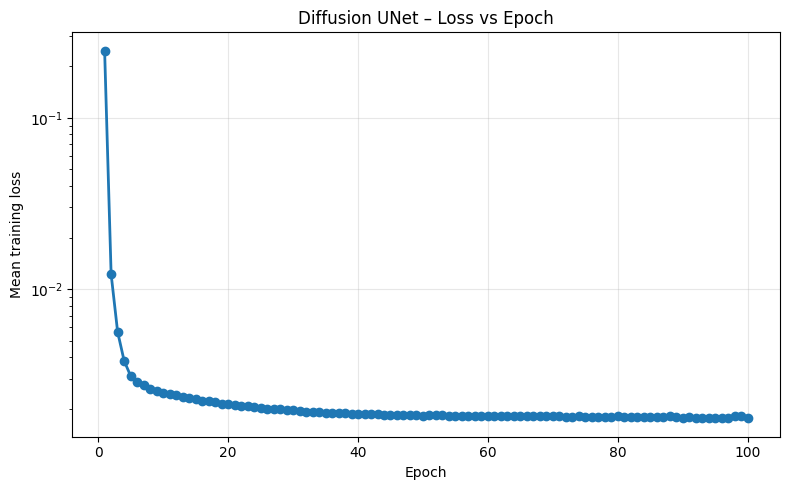

Saved plot to: F:/loss_curve_unet_from_log.png


In [4]:
import re
import numpy as np
import matplotlib.pyplot as plt

# =========================================
# 1) Paste your log between the """ ... """
# =========================================
log_text = """
===== Epoch 1/100 =====
[Epoch 1] Batch 1/12 | global step 0
Epoch 1 done. Mean loss: 0.246180

===== Epoch 2/100 =====
[Epoch 2] Batch 1/12 | global step 12
Epoch 2 done. Mean loss: 0.012239

===== Epoch 3/100 =====
[Epoch 3] Batch 1/12 | global step 24
Epoch 3 done. Mean loss: 0.005640

===== Epoch 4/100 =====
[Epoch 4] Batch 1/12 | global step 36
Epoch 4 done. Mean loss: 0.003828

===== Epoch 5/100 =====
[Epoch 5] Batch 1/12 | global step 48
Epoch 5 done. Mean loss: 0.003121

===== Epoch 6/100 =====
[Epoch 6] Batch 1/12 | global step 60
Epoch 6 done. Mean loss: 0.002876

===== Epoch 7/100 =====
[Epoch 7] Batch 1/12 | global step 72
Epoch 7 done. Mean loss: 0.002752

===== Epoch 8/100 =====
[Epoch 8] Batch 1/12 | global step 84
Epoch 8 done. Mean loss: 0.002605

===== Epoch 9/100 =====
[Epoch 9] Batch 1/12 | global step 96
Epoch 9 done. Mean loss: 0.002556

===== Epoch 10/100 =====
[Epoch 10] Batch 1/12 | global step 108
Epoch 10 done. Mean loss: 0.002494

===== Epoch 11/100 =====
[Epoch 11] Batch 1/12 | global step 120
Epoch 11 done. Mean loss: 0.002437

===== Epoch 12/100 =====
[Epoch 12] Batch 1/12 | global step 132
Epoch 12 done. Mean loss: 0.002400

===== Epoch 13/100 =====
[Epoch 13] Batch 1/12 | global step 144
Epoch 13 done. Mean loss: 0.002351

===== Epoch 14/100 =====
[Epoch 14] Batch 1/12 | global step 156
Epoch 14 done. Mean loss: 0.002326

===== Epoch 15/100 =====
[Epoch 15] Batch 1/12 | global step 168
Epoch 15 done. Mean loss: 0.002277

===== Epoch 16/100 =====
[Epoch 16] Batch 1/12 | global step 180
Epoch 16 done. Mean loss: 0.002241

===== Epoch 17/100 =====
[Epoch 17] Batch 1/12 | global step 192
[Epoch 17 | Step 8/12 | Global 200] Loss: 0.002278
Epoch 17 done. Mean loss: 0.002215

===== Epoch 18/100 =====
[Epoch 18] Batch 1/12 | global step 204
Epoch 18 done. Mean loss: 0.002191

===== Epoch 19/100 =====
[Epoch 19] Batch 1/12 | global step 216
Epoch 19 done. Mean loss: 0.002153

===== Epoch 20/100 =====
[Epoch 20] Batch 1/12 | global step 228
Epoch 20 done. Mean loss: 0.002136

===== Epoch 21/100 =====
[Epoch 21] Batch 1/12 | global step 240
Epoch 21 done. Mean loss: 0.002112

===== Epoch 22/100 =====
[Epoch 22] Batch 1/12 | global step 252
Epoch 22 done. Mean loss: 0.002089

===== Epoch 23/100 =====
[Epoch 23] Batch 1/12 | global step 264
Epoch 23 done. Mean loss: 0.002071

===== Epoch 24/100 =====
[Epoch 24] Batch 1/12 | global step 276
Epoch 24 done. Mean loss: 0.002046

===== Epoch 25/100 =====
[Epoch 25] Batch 1/12 | global step 288
Epoch 25 done. Mean loss: 0.002039

===== Epoch 26/100 =====
[Epoch 26] Batch 1/12 | global step 300
Epoch 26 done. Mean loss: 0.002009

===== Epoch 27/100 =====
[Epoch 27] Batch 1/12 | global step 312
Epoch 27 done. Mean loss: 0.001998

===== Epoch 28/100 =====
[Epoch 28] Batch 1/12 | global step 324
Epoch 28 done. Mean loss: 0.001989

===== Epoch 29/100 =====
[Epoch 29] Batch 1/12 | global step 336
Epoch 29 done. Mean loss: 0.001967

===== Epoch 30/100 =====
[Epoch 30] Batch 1/12 | global step 348
Epoch 30 done. Mean loss: 0.001963

===== Epoch 31/100 =====
[Epoch 31] Batch 1/12 | global step 360
Epoch 31 done. Mean loss: 0.001940

===== Epoch 32/100 =====
[Epoch 32] Batch 1/12 | global step 372
Epoch 32 done. Mean loss: 0.001934

===== Epoch 33/100 =====
[Epoch 33] Batch 1/12 | global step 384
Epoch 33 done. Mean loss: 0.001929

===== Epoch 34/100 =====
[Epoch 34] Batch 1/12 | global step 396
[Epoch 34 | Step 4/12 | Global 400] Loss: 0.001969
Epoch 34 done. Mean loss: 0.001916

===== Epoch 35/100 =====
[Epoch 35] Batch 1/12 | global step 408
Epoch 35 done. Mean loss: 0.001908

===== Epoch 36/100 =====
[Epoch 36] Batch 1/12 | global step 420
Epoch 36 done. Mean loss: 0.001898

===== Epoch 37/100 =====
[Epoch 37] Batch 1/12 | global step 432
Epoch 37 done. Mean loss: 0.001898

===== Epoch 38/100 =====
[Epoch 38] Batch 1/12 | global step 444
Epoch 38 done. Mean loss: 0.001891

===== Epoch 39/100 =====
[Epoch 39] Batch 1/12 | global step 456
Epoch 39 done. Mean loss: 0.001878

===== Epoch 40/100 =====
[Epoch 40] Batch 1/12 | global step 468
Epoch 40 done. Mean loss: 0.001873

===== Epoch 41/100 =====
[Epoch 41] Batch 1/12 | global step 480
Epoch 41 done. Mean loss: 0.001867

===== Epoch 42/100 =====
[Epoch 42] Batch 1/12 | global step 492
Epoch 42 done. Mean loss: 0.001870

===== Epoch 43/100 =====
[Epoch 43] Batch 1/12 | global step 504
Epoch 43 done. Mean loss: 0.001861

===== Epoch 44/100 =====
[Epoch 44] Batch 1/12 | global step 516
Epoch 44 done. Mean loss: 0.001854

===== Epoch 45/100 =====
[Epoch 45] Batch 1/12 | global step 528
Epoch 45 done. Mean loss: 0.001850

===== Epoch 46/100 =====
[Epoch 46] Batch 1/12 | global step 540
Epoch 46 done. Mean loss: 0.001851

===== Epoch 47/100 =====
[Epoch 47] Batch 1/12 | global step 552
Epoch 47 done. Mean loss: 0.001848

===== Epoch 48/100 =====
[Epoch 48] Batch 1/12 | global step 564
Epoch 48 done. Mean loss: 0.001845

===== Epoch 49/100 =====
[Epoch 49] Batch 1/12 | global step 576
Epoch 49 done. Mean loss: 0.001849

===== Epoch 50/100 =====
[Epoch 50] Batch 1/12 | global step 588
[Epoch 50 | Step 12/12 | Global 600] Loss: 0.001796
Epoch 50 done. Mean loss: 0.001832

===== Epoch 51/100 =====
[Epoch 51] Batch 1/12 | global step 600
Epoch 51 done. Mean loss: 0.001835

===== Epoch 52/100 =====
[Epoch 52] Batch 1/12 | global step 612
Epoch 52 done. Mean loss: 0.001838

===== Epoch 53/100 =====
[Epoch 53] Batch 1/12 | global step 624
Epoch 53 done. Mean loss: 0.001837

===== Epoch 54/100 =====
[Epoch 54] Batch 1/12 | global step 636
Epoch 54 done. Mean loss: 0.001829

===== Epoch 55/100 =====
[Epoch 55] Batch 1/12 | global step 648
Epoch 55 done. Mean loss: 0.001822

===== Epoch 56/100 =====
[Epoch 56] Batch 1/12 | global step 660
Epoch 56 done. Mean loss: 0.001822

===== Epoch 57/100 =====
[Epoch 57] Batch 1/12 | global step 672
Epoch 57 done. Mean loss: 0.001822

===== Epoch 58/100 =====
[Epoch 58] Batch 1/12 | global step 684
Epoch 58 done. Mean loss: 0.001826

===== Epoch 59/100 =====
[Epoch 59] Batch 1/12 | global step 696
Epoch 59 done. Mean loss: 0.001819

===== Epoch 60/100 =====
[Epoch 60] Batch 1/12 | global step 708
Epoch 60 done. Mean loss: 0.001821

===== Epoch 61/100 =====
[Epoch 61] Batch 1/12 | global step 720
Epoch 61 done. Mean loss: 0.001818

===== Epoch 62/100 =====
[Epoch 62] Batch 1/12 | global step 732
Epoch 62 done. Mean loss: 0.001820

===== Epoch 63/100 =====
[Epoch 63] Batch 1/12 | global step 744
Epoch 63 done. Mean loss: 0.001818

===== Epoch 64/100 =====
[Epoch 64] Batch 1/12 | global step 756
Epoch 64 done. Mean loss: 0.001823

===== Epoch 65/100 =====
[Epoch 65] Batch 1/12 | global step 768
Epoch 65 done. Mean loss: 0.001826

===== Epoch 66/100 =====
[Epoch 66] Batch 1/12 | global step 780
Epoch 66 done. Mean loss: 0.001816

===== Epoch 67/100 =====
[Epoch 67] Batch 1/12 | global step 792
[Epoch 67 | Step 8/12 | Global 800] Loss: 0.001802
Epoch 67 done. Mean loss: 0.001812

===== Epoch 68/100 =====
[Epoch 68] Batch 1/12 | global step 804
Epoch 68 done. Mean loss: 0.001814

===== Epoch 69/100 =====
[Epoch 69] Batch 1/12 | global step 816
Epoch 69 done. Mean loss: 0.001813

===== Epoch 70/100 =====
[Epoch 70] Batch 1/12 | global step 828
Epoch 70 done. Mean loss: 0.001814

===== Epoch 71/100 =====
[Epoch 71] Batch 1/12 | global step 840
Epoch 71 done. Mean loss: 0.001812

===== Epoch 72/100 =====
[Epoch 72] Batch 1/12 | global step 852
Epoch 72 done. Mean loss: 0.001808

===== Epoch 73/100 =====
[Epoch 73] Batch 1/12 | global step 864
Epoch 73 done. Mean loss: 0.001807

===== Epoch 74/100 =====
[Epoch 74] Batch 1/12 | global step 876
Epoch 74 done. Mean loss: 0.001818

===== Epoch 75/100 =====
[Epoch 75] Batch 1/12 | global step 888
Epoch 75 done. Mean loss: 0.001808

===== Epoch 76/100 =====
[Epoch 76] Batch 1/12 | global step 900
Epoch 76 done. Mean loss: 0.001795

===== Epoch 77/100 =====
[Epoch 77] Batch 1/12 | global step 912
Epoch 77 done. Mean loss: 0.001802

===== Epoch 78/100 =====
[Epoch 78] Batch 1/12 | global step 924
Epoch 78 done. Mean loss: 0.001803

===== Epoch 79/100 =====
[Epoch 79] Batch 1/12 | global step 936
Epoch 79 done. Mean loss: 0.001799

===== Epoch 80/100 =====
[Epoch 80] Batch 1/12 | global step 948
Epoch 80 done. Mean loss: 0.001819

===== Epoch 81/100 =====
[Epoch 81] Batch 1/12 | global step 960
Epoch 81 done. Mean loss: 0.001808

===== Epoch 82/100 =====
[Epoch 82] Batch 1/12 | global step 972
Epoch 82 done. Mean loss: 0.001790

===== Epoch 83/100 =====
[Epoch 83] Batch 1/12 | global step 984
Epoch 83 done. Mean loss: 0.001804

===== Epoch 84/100 =====
[Epoch 84] Batch 1/12 | global step 996
[Epoch 84 | Step 4/12 | Global 1000] Loss: 0.001753
Epoch 84 done. Mean loss: 0.001798

===== Epoch 85/100 =====
[Epoch 85] Batch 1/12 | global step 1008
Epoch 85 done. Mean loss: 0.001792

===== Epoch 86/100 =====
[Epoch 86] Batch 1/12 | global step 1020
Epoch 86 done. Mean loss: 0.001800

===== Epoch 87/100 =====
[Epoch 87] Batch 1/12 | global step 1032
Epoch 87 done. Mean loss: 0.001808

===== Epoch 88/100 =====
[Epoch 88] Batch 1/12 | global step 1044
Epoch 88 done. Mean loss: 0.001812

===== Epoch 89/100 =====
[Epoch 89] Batch 1/12 | global step 1056
Epoch 89 done. Mean loss: 0.001803

===== Epoch 90/100 =====
[Epoch 90] Batch 1/12 | global step 1068
Epoch 90 done. Mean loss: 0.001778

===== Epoch 91/100 =====
[Epoch 91] Batch 1/12 | global step 1080
Epoch 91 done. Mean loss: 0.001788

===== Epoch 92/100 =====
[Epoch 92] Batch 1/12 | global step 1092
Epoch 92 done. Mean loss: 0.001774

===== Epoch 93/100 =====
[Epoch 93] Batch 1/12 | global step 1104
Epoch 93 done. Mean loss: 0.001765

===== Epoch 94/100 =====
[Epoch 94] Batch 1/12 | global step 1116
Epoch 94 done. Mean loss: 0.001773

===== Epoch 95/100 =====
[Epoch 95] Batch 1/12 | global step 1128
Epoch 95 done. Mean loss: 0.001773

===== Epoch 96/100 =====
[Epoch 96] Batch 1/12 | global step 1140
Epoch 96 done. Mean loss: 0.001780

===== Epoch 97/100 =====
[Epoch 97] Batch 1/12 | global step 1152
Epoch 97 done. Mean loss: 0.001778

===== Epoch 98/100 =====
[Epoch 98] Batch 1/12 | global step 1164
Epoch 98 done. Mean loss: 0.001819

===== Epoch 99/100 =====
[Epoch 99] Batch 1/12 | global step 1176
Epoch 99 done. Mean loss: 0.001810

===== Epoch 100/100 =====
[Epoch 100] Batch 1/12 | global step 1188
[Epoch 100 | Step 12/12 | Global 1200] Loss: 0.001760
Epoch 100 done. Mean loss: 0.001780
"""

# =========================================
# 2) Extract mean losses from the log
# =========================================
losses = [float(x) for x in re.findall(r"Mean loss:\s*([0-9.]+)", log_text)]
epochs = np.arange(1, len(losses) + 1)

print(f"Parsed {len(losses)} epochs")
print(losses[:5], "...")

# =========================================
# 3) Plot loss vs epoch
# =========================================
plt.figure(figsize=(8, 5))
plt.plot(epochs, losses, marker='o', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Mean training loss")
plt.title("Diffusion UNet – Loss vs Epoch")
plt.grid(True, alpha=0.3)
plt.yscale("log")  # log scale is usually nice for these curves

# Save next to your other outputs
out_path = "F:/loss_curve_unet_from_log.png"
plt.tight_layout()
plt.savefig(out_path, dpi=300)
plt.show()

print("Saved plot to:", out_path)
